In [23]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import load_data
import pre_processing_utils as ppu


# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

In [6]:
# load data

xt, xt_test, vaep, vaep_test, games, games_test, players, players_test, target_players = load_data.load_data('s3')

## Feature Selection, Encoding and Pre-processing 

- Check class balances 
- Deal with imbalances 
- Encode categorical columns - we can do column transformations as part of GridSearch
- Split into Test and Train
- Scale Data


In [8]:
modeling_train_df = vaep.copy()
modeling_test_df = vaep_test.copy()



## Player approach

**Description:**

- Fit a model to a potential transfer player (this is a new player that we may want to add to the team)
- Once we have the player fitted, we will pass data from the current player in our team that we want to replace
- The reasoning for this is that we capture how the new player plays through the model we fit and then we capture how our team plays, in the context of the position our existing player occupies, through the area of the pitch that the player receives the ball in
- We will then aim to classify what action the new player may take from similar positions on the pitch
- To avoid any data leaking we will only use data where the previous moves in the dataset do not belong to the player we are trying to fit the model to (those are the ```n-x...``` columns)
- For the baseline model, we will only aim to predict the new player's actions, just see if the model is at the very minimum able to accurately predict the same player's next actions.

In [5]:
# for the baseline model we will look for the players that played the most, by the number of minutes played
players.groupby('player_id')['minutes_played'].sum().sort_values(ascending=False).head()

player_id
10185    3450
15709    3278
4633     3260
4658     3257
16376    3242
Name: minutes_played, dtype: int64

In [6]:
# player_id = 10185

player_id = 15709

### Data Pre-Processing

**Approach:**

- Scale numerical columns 
- OneHotEncode categorical columns
- Drop any columns, which either risk leaking data into the model - or we wouldn't know when making predictions as they are tied to the action itself, such as body-part, which we wouldn't know when making predictions on new, unseen data. 
- Will create a column transformer that we can feed into a pipeline

**Pre-processing steps:**

- view numerical distributions 
- check correlations

# Preprocessing and data-setup

1. Column Transformer

2. Data filter

## Classification Approach

#### Baseline Models - Team Next-action 

In [19]:
games['away_team_id'].unique()

array([ 971,  969,  970,  968,  974,  965,  973,  966,  967,  746,  972,
       1475,  749])

In [12]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id', 1475, modeling_train_df, modeling_test_df, 'type_name_encoded')

In [10]:
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [22]:
print('*** Logistic Regression ***')
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train)
print('Logistic Regression Train Score: ', pipe.score(X_train, y_train))
print('Logistic Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Support Vector Machine ***')
pipe_svm = make_pipeline(ct, svm.SVC())
pipe_svm.fit(X_train, y_train)
print('SVM Train Score: ', pipe_svm.score(X_train, y_train))
print('SVM Test Score: ', pipe_svm.score(X_test, y_test))
print(' ')

print('*** Decision Tree Classifier ***')
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train)
print('Decision Tree Train Score: ', pipe.score(X_train, y_train))
print('Decision Tree Test Score: ',pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Classifier ***')
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))

*** Logistic Regression ***
Logistic Regression Train Score:  0.7943245403677058
Logistic Regression Test Score:  0.7766516002374104
 
*** Support Vector Machine ***
SVM Train Score:  0.8388489208633093
SVM Test Score:  0.7867871981007168
 
*** Decision Tree Classifier ***
Decision Tree Train Score:  1.0
Decision Tree Test Score:  0.7357439620143359
 
*** Random Forest Classifier ***
Random Forest Train Score:  1.0
Random Forest Test Score:  0.7991599324293476


In [13]:
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('player-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [14]:
transformed_train_df = ct.fit_transform(X_train)
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
    
transformed_train_df = pd.DataFrame(transformed_train_df, columns=column_names)
transformed_train_df.head()

,start_x,start_y,time_seconds,n-1_x_distance,n-1_y_distance,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-1_offensive_value,...,n-5_type_name_encoded_other,n-5_type_name_encoded_pass,n-5_result_name_fail,n-5_result_name_offside,n-5_result_name_owngoal,n-5_result_name_success,n-5_result_name_yellow_card,n-5_bodypart_name_foot,n-5_bodypart_name_head,n-5_bodypart_name_other
0,0.366746,0.134342,-1.673004,0.653737,1.038048,-0.632404,-0.764097,-0.323895,-0.236466,-0.066024,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.145415,0.737489,-1.664715,4.094992,-0.691638,-0.684397,-0.525351,1.206457,-0.881406,0.426607,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.528272,1.344739,-1.662347,0.939926,1.191618,-1.110092,0.738358,-0.663973,1.351078,-0.042315,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.528272,1.344739,-1.662347,-0.393299,-0.004613,-0.489423,1.347573,-0.663973,1.351078,-0.112860,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.932162,1.065733,-1.661162,-1.265828,-0.554233,-0.489423,1.347573,-1.065008,1.069950,-0.068296,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Baseline Models - Player next action

In [29]:
print('*** Logistic Regression ***')
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_type)
print('Logistic Regression Train Score: ', pipe.score(X_train, y_train_type))
print('Logistic Regression Test Score: ', pipe.score(X_test, y_test_type))
print(' ')

print('*** Support Vector Machine ***')
pipe_svm = make_pipeline(ct, svm.SVC())
pipe_svm.fit(X_train, y_train_type)
print('SVM Train Score: ', pipe_svm.score(X_train, y_train_type))
print('SVM Test Score: ', pipe_svm.score(X_test, y_test_type))
print(' ')

print('*** Decision Tree Classifier ***')
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print('Decision Tree Train Score: ', pipe.score(X_train, y_train_type))
print('Decision Tree Test Score: ',pipe.score(X_test, y_test_type))
print(' ')

print('*** Random Forest Classifier ***')
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train_type)
print('Random Forest Train Score: ', pipe.score(X_train, y_train_type))
print('Random Forest Test Score: ',pipe.score(X_test, y_test_type))

*** Logistic Regression ***
Logistic Regression Train Score:  0.9048361934477379
Logistic Regression Test Score:  0.7870036101083032
 
*** Support Vector Machine ***
SVM Train Score:  0.8876755070202809
SVM Test Score:  0.7924187725631769
 
*** Decision Tree Classifier ***
Decision Tree Train Score:  1.0
Decision Tree Test Score:  0.776173285198556
 
*** Random Forest Classifier ***
Random Forest Train Score:  1.0
Random Forest Test Score:  0.8375451263537906


### Baseline Models - Team end zone

In [19]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id', 1475, modeling_train_df, modeling_test_df, 'end_pitch_zone')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-end')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [36]:
print('*** Logistic Regression ***')
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train)
print('Logistic Regression Train Score: ', pipe.score(X_train, y_train))
print('Logistic Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Support Vector Machine ***')
pipe = make_pipeline(ct, svm.SVC())
pipe.fit(X_train, y_train)
print('SVM Train Score: ',pipe.score(X_train, y_train))
print('SVM Test Score: ',pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Classifier ***')
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train)
print('Decision Tree Train Score: ', pipe.score(X_train, y_train))
print('Decision Tree Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Classifier ***')
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Classifier ***')
pipe = make_pipeline(ct, xgb.XGBClassifier())
pipe.fit(X_train, y_train)
print('XGB Train Score: ', pipe.score(X_train, y_train))
print('XGB Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Logistic Regression ***
Logistic Regression Train Score:  0.7254196642685852
Logistic Regression Test Score:  0.6931927133269415
 
*** Support Vector Machine ***
SVM Train Score:  0.7243005595523581
SVM Test Score:  0.6851572843902661
 
*** Decision Tree Classifier ***
Decision Tree Train Score:  1.0
Decision Tree Test Score:  0.6195041775099301
 
*** Random Forest Classifier ***
Random Forest Train Score:  1.0
Random Forest Test Score:  0.7105875907409944
 
*** xGBoost Classifier ***
[23:27:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score:  1.0
XGB Test Score:  0.7210427795279185
 


### Baseline Models - Player end zone

In [30]:
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('player-end')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [32]:
print('*** Logistic Regression ***')
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_end_zone)
print('Logistic Regression Train Score: ', pipe.score(X_train, y_train_end_zone))
print('Logistic Regression Test Score: ', pipe.score(X_test, y_test_end_zone))
print(' ')

print('*** Support Vector Machine ***')
pipe = make_pipeline(ct, svm.SVC())
pipe.fit(X_train, y_train_end_zone)
print('SVM Train Score: ',pipe.score(X_train, y_train_end_zone))
print('SVM Test Score: ',pipe.score(X_test, y_test_end_zone))
print(' ')

print('*** Decision Tree Classifier ***')
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_end_zone)
print('Decision Tree Train Score: ', pipe.score(X_train, y_train_end_zone))
print('Decision Tree Test Score: ', pipe.score(X_test, y_test_end_zone))
print(' ')

print('*** Random Forest Classifier ***')
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train_end_zone)
print('Random Forest Train Score: ', pipe.score(X_train, y_train_end_zone))
print('Random Forest Test Score: ', pipe.score(X_test, y_test_end_zone))
print(' ')

print('*** xGBoost Classifier ***')
pipe = make_pipeline(ct, xgb.XGBClassifier())
pipe.fit(X_train, y_train_end_zone)
print('XGB Train Score: ', pipe.score(X_train, y_train_end_zone))
print('XGB Test Score: ', pipe.score(X_test, y_test_end_zone))
print(' ')

*** Logistic Regression ***
Logistic Regression Train Score:  0.8533541341653667
Logistic Regression Test Score:  0.6588447653429603
 
*** Support Vector Machine ***
SVM Train Score:  0.7847113884555382
SVM Test Score:  0.6389891696750902
 
*** Decision Tree Classifier ***
Decision Tree Train Score:  1.0
Decision Tree Test Score:  0.6245487364620939
 
*** Random Forest Classifier ***
Random Forest Train Score:  1.0
Random Forest Test Score:  0.6805054151624549
 
*** xGBoost Classifier ***
[23:23:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score:  1.0
XGB Test Score:  0.6985559566787004
 


**Initial Observations:**

- Initial scores look promising for the next action, but not great for the end zone
- However, with the player approach, we are cutting the dataset down significantly - therefore will look to fit a model to a team, which is the team that is looking to add another player in. Then will use this model to predict the actions and endzones for a new player. 
- To validate the accuracy of the model, will use a list of players that transferred teams to see if the model based on their pre-transfer data, accurately predicts their post-transfer outcomes

## Regression Models

### Baseline Models - Team Models VAEP

In [39]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id', 1475, modeling_train_df, modeling_test_df, 'vaep_value')

In [40]:
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-vaep')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('drop', drop_features))

In [41]:
print('*** Linear Regression ***')
pipe = make_pipeline(ct, LinearRegression())
pipe.fit(X_train, y_train)
print('Linear Regression Train Score: ', pipe.score(X_train, y_train))
print('Linear Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Ridge Regression ***')
pipe = make_pipeline(ct, Ridge(alpha=5))
pipe.fit(X_train, y_train)
print('Ridge Regression Train Score: ', pipe.score(X_train, y_train))
print('Ridge Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Regressor ***')
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 2 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=2))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 7 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=7))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 12 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=12))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor ***')
pipe = make_pipeline(ct, xgb.XGBRegressor())
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Linear Regression ***
Linear Regression Train Score:  0.12724488739077233
Linear Regression Test Score:  -2.4275149566971205e+21
 
*** Ridge Regression ***
Ridge Regression Train Score:  0.12700639244358913
Ridge Regression Test Score:  0.08397810382014181
 
*** Decision Tree Regressor ***
DT Train Score:  1.0
DT Test Score:  0.6803650258210291
 
*** Random Forest Regressor - Depth 2 ***
Random Forest Train Score:  0.6043440666903013
Random Forest Test Score:  0.622007172000401
 
*** Random Forest Regressor - Depth 7 ***
Random Forest Train Score:  0.8717183359811463
Random Forest Test Score:  0.7573610532370921
 
*** Random Forest Regressor - Depth 12 ***
Random Forest Train Score:  0.9444878601480747
Random Forest Test Score:  0.7738544538526914
 
*** xGBoost Regressor ***
XGB Regressor Train Score:  0.9885390128522835
XGB Regressor Test Score:  0.7766312638696431
 


### Baseline Models - Player VAEP

In [43]:
X_train, y_train, X_test, y_test = ppu.create_player_data('regression', modeling_train_df, modeling_test_df, player_id, reg_target = 'vaep_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('player-vaep')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [44]:
print('*** Linear Regression ***')
pipe = make_pipeline(ct, LinearRegression())
pipe.fit(X_train, y_train)
print('Linear Regression Train Score: ', pipe.score(X_train, y_train))
print('Linear Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Ridge Regression ***')
pipe = make_pipeline(ct, Ridge(alpha=5))
pipe.fit(X_train, y_train)
print('Ridge Regression Train Score: ', pipe.score(X_train, y_train))
print('Ridge Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Regressor ***')
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 2 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=2))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 7 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=7))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 12 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=12))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor ***')
pipe = make_pipeline(ct, xgb.XGBRegressor())
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Linear Regression ***
Linear Regression Train Score:  0.46952001294503865
Linear Regression Test Score:  -8.652077660654941e+20
 
*** Ridge Regression ***
Ridge Regression Train Score:  0.330134243543302
Ridge Regression Test Score:  -0.19102296420273102
 
*** Decision Tree Regressor ***
DT Train Score:  1.0
DT Test Score:  -0.33607084713970226
 
*** Random Forest Regressor - Depth 2 ***
Random Forest Train Score:  0.43594442303386394
Random Forest Test Score:  0.10722257093858778
 
*** Random Forest Regressor - Depth 7 ***
Random Forest Train Score:  0.8383193381657965
Random Forest Test Score:  0.05373519651801262
 
*** Random Forest Regressor - Depth 12 ***
Random Forest Train Score:  0.8849920637349
Random Forest Test Score:  0.03855590208814452
 
*** xGBoost Regressor ***
XGB Regressor Train Score:  0.9977614682464013
XGB Regressor Test Score:  0.045975565446761624
 


### Baseline Models - xT - Team model

In [45]:
modeling_xt_train_df = xt.copy()
modeling_xt_test_df = xt_test.copy()

In [47]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id', 1475, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-xt')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [48]:
print('*** Linear Regression ***')
pipe = make_pipeline(ct, LinearRegression())
pipe.fit(X_train, y_train)
print('Linear Regression Train Score: ', pipe.score(X_train, y_train))
print('Linear Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Ridge Regression ***')
pipe = make_pipeline(ct, Ridge(alpha=5))
pipe.fit(X_train, y_train)
print('Ridge Regression Train Score: ', pipe.score(X_train, y_train))
print('Ridge Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Regressor ***')
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 2 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=2))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 7 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=7))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 12 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=12))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor ***')
pipe = make_pipeline(ct, xgb.XGBRegressor())
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Linear Regression ***
Linear Regression Train Score:  0.48643729697146787
Linear Regression Test Score:  0.40977417210842426
 
*** Ridge Regression ***
Ridge Regression Train Score:  0.4864246033693257
Ridge Regression Test Score:  0.4067522942546975
 
*** Decision Tree Regressor ***
DT Train Score:  0.9999999999999997
DT Test Score:  0.8941230264107702
 
*** Random Forest Regressor - Depth 2 ***
Random Forest Train Score:  0.42105427747780744
Random Forest Test Score:  0.38409222741183335
 
*** Random Forest Regressor - Depth 7 ***
Random Forest Train Score:  0.8946394954021685
Random Forest Test Score:  0.8034156275735524
 
*** Random Forest Regressor - Depth 12 ***
Random Forest Train Score:  0.9443766731343598
Random Forest Test Score:  0.8266141205968918
 
*** xGBoost Regressor ***
XGB Regressor Train Score:  0.9982139820125835
XGB Regressor Test Score:  0.8948343919835969
 


### Baseline Models - xT - Player model

In [49]:
X_train, y_train, X_test, y_test = ppu.create_player_data('regression', modeling_xt_train_df, modeling_xt_test_df, player_id, reg_target = 'xT_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('player-xt')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [51]:
print('*** Linear Regression ***')
pipe = make_pipeline(ct, LinearRegression())
pipe.fit(X_train, y_train)
print('Linear Regression Train Score: ', pipe.score(X_train, y_train))
print('Linear Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Ridge Regression ***')
pipe = make_pipeline(ct, Ridge(alpha=5))
pipe.fit(X_train, y_train)
print('Ridge Regression Train Score: ', pipe.score(X_train, y_train))
print('Ridge Regression Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Regressor ***')
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 2 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=2))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 7 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=7))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 12 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=12))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor ***')
pipe = make_pipeline(ct, xgb.XGBRegressor())
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Linear Regression ***
Linear Regression Train Score:  0.7880125268534228
Linear Regression Test Score:  0.7965256841608219
 
*** Ridge Regression ***
Ridge Regression Train Score:  0.7492012510899699
Ridge Regression Test Score:  0.7790441511774474
 
*** Decision Tree Regressor ***
DT Train Score:  1.0
DT Test Score:  0.9660339421402276
 
*** Random Forest Regressor - Depth 2 ***
Random Forest Train Score:  0.9067107402549921
Random Forest Test Score:  0.8950089548832655
 
*** Random Forest Regressor - Depth 7 ***
Random Forest Train Score:  0.9677269601977027
Random Forest Test Score:  0.9595043474553674
 
*** Random Forest Regressor - Depth 12 ***
Random Forest Train Score:  0.9697359947829295
Random Forest Test Score:  0.9569295135560913
 
*** xGBoost Regressor ***
XGB Regressor Train Score:  0.9969456780096091
XGB Regressor Test Score:  0.9632074694780917
 


## Model Scoring Approach

In [71]:
target_players.head()

,player_id,player_name,minutes_played
0,24239,Jemma Elizabeth Purfield,2016
1,15579,Inessa Kaagman,2015
2,5076,Emily Louise van Egmond,1940
3,5074,Shelina Laura Zadorsky,1930
4,31534,Ella Toone,1887


In [96]:
players[players['player_id']==15579].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
276,19734,967,15579,Inessa Kaagman,NaN,8,True,21,Left Wing,94


In [97]:
players_test[players_test['player_id']==15579].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
100,3775570,965,15579,Inessa Kaagman,NaN,10,True,16,Left Midfield,95


#### Get player data from seasons 1 & 2 - from their prior team

**Note:** training data did not contain this dataset

In [138]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==965].dropna()
# team_test_set = modeling_test_df[(modeling_test_df['team_id']==965)&(modeling_test_df['player_id']==15579)].dropna()
team_test_set = modeling_test_df[modeling_test_df['team_id']==965].dropna()

X_train = team_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = team_train_set['type_name_encoded']
y_train_end_zone = team_train_set['end_pitch_zone']

X_test = team_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = team_test_set['type_name_encoded']
y_test_end_zone = team_test_set['end_pitch_zone']

In [139]:
numeric_features, categorical_features, drop_features = col_transformer.set_ct_mode('team-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [140]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.6950657333105685


In [141]:
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.999963939273737
0.7799214614990609


In [82]:
modeling_train_df[modeling_train_df['player_id']==15579].shape

(1934, 122)

- predict player actions using team model trained on season 1&2 and new player's data from season 1&2 with their old team

In [83]:
predictions = pipe.predict(modeling_train_df[modeling_train_df['player_id']==15579].dropna())

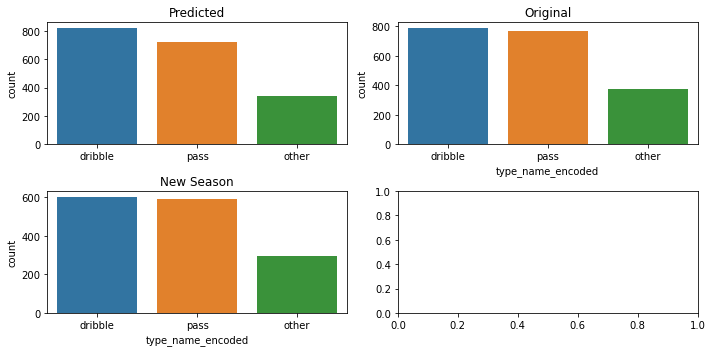

In [84]:
plt.subplots(2,2, figsize=(10,5))
plt.subplot(2,2,1)
sns.countplot(predictions)
plt.title('Predicted')

plt.subplot(2,2,2)
sns.countplot(modeling_train_df[modeling_train_df['player_id']==15579]['type_name_encoded'].dropna())
plt.title('Original')

plt.subplot(2,2,3)
sns.countplot(modeling_test_df[modeling_test_df['player_id']==15579]['type_name_encoded'].dropna())
plt.title("New Season")
plt.tight_layout()
plt.show()

In [105]:
prediction_matrix = modeling_train_df[modeling_train_df['player_id']==15579].dropna()[['type_name_encoded']]

# prediction_matrix.rename(columns={0:'Prediction'}, inplace=True)

In [106]:
prediction_matrix['prediction'] = predictions

In [107]:
prediction_matrix['hit'] = [1 if x['type_name_encoded'] == x['prediction'] else 0 for i,x in prediction_matrix.iterrows()]

In [108]:
prediction_matrix['hit'].mean()

0.7793726741095162

## Modeling 

**Approach to modeling:**

1. Pick a player to replace in a team
2. Get the top players in their cluster as potential replacements 
3. Fit a model for each of the scouted players 
    - use only that player's data to fit the model
    - the models will predict their next location and the action they take 
    - the parameters in the model should cover the player characteristics and team characteristics. For example, the 5 past moves cover what the team does, and how then the player reacts to those. The player action is the predicted target 

**Model validation and testing approach:**

- Of the scouted players, find those that have undergone a transfer in season 3 in our data set - use season 3 data to test our predictions. 
- Score the model based on the real data from their new team


**Models to train and test:**

- Baseline model for logistic regression for next action and end pitch location
- Random Forest classifier for end pitch location and next action 
- xGBoost classifier for end pitch location and next action 
- Random Forest regressor for end_x and end_y location 
- xGBoost regressor for enx_x and end_y location

## APPENDIX - Clustering players

In [4]:
clustering_df = vaep.groupby(['player_id','start_pitch_zone'])['start_x','start_y'].mean().reset_index()

clustering_df['frequency'] = vaep.groupby(['player_id', 'start_pitch_zone'])[['start_pitch_zone']].value_counts().values

In [5]:
clustering_df.head()

,player_id,start_pitch_zone,start_x,start_y,frequency
0,4633.0,zone_1,22.525882,16.078987,75
1,4633.0,zone_2,22.263363,38.728213,635
2,4633.0,zone_3,22.498169,54.164551,1349
3,4633.0,zone_4,48.187500,17.367018,72
4,4633.0,zone_5,47.773566,38.150974,717


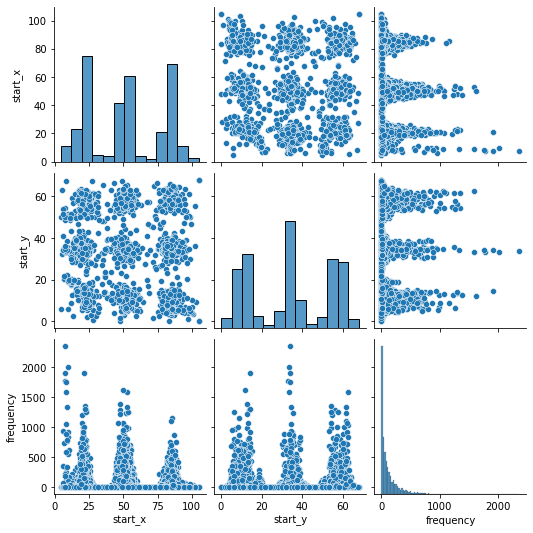

In [6]:
sns.pairplot(clustering_df[['start_pitch_zone', 'start_x', 'start_y','frequency']])
plt.show()

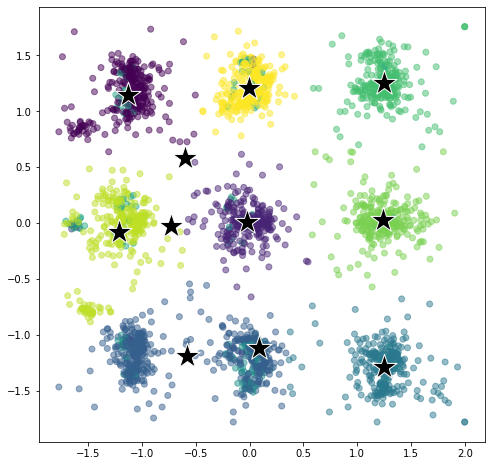

In [7]:
X = clustering_df[['start_x','start_y', 'frequency']]

ss = StandardScaler()
X = ss.fit_transform(X)

# Instantiate
k_means_model_2= KMeans(n_clusters=11)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()

In [8]:
clustering_df['cluster_labels'] = cluster_labels

In [9]:
# We will explore different values for k, and look at the scree plot ('elbow method') 
# using inertia. We will also look at the silhouette score

ks = np.arange(2, 30)
inertia_list = []
silhouette_score_list = []

for k in ks:

    # Instantiate
    my_kmeans = KMeans(n_clusters=k)
    
    # Fit (i.e. get clusters)
    y_labels = my_kmeans.fit_predict(X)
    
    # Append inertia
    inertia_list.append(my_kmeans.inertia_)

    # Append silhouette
    silhouette = silhouette_score(X, y_labels)
    silhouette_score_list.append(silhouette)

In [10]:
np.arange(2,30)[np.argmax(silhouette_score_list)]

25

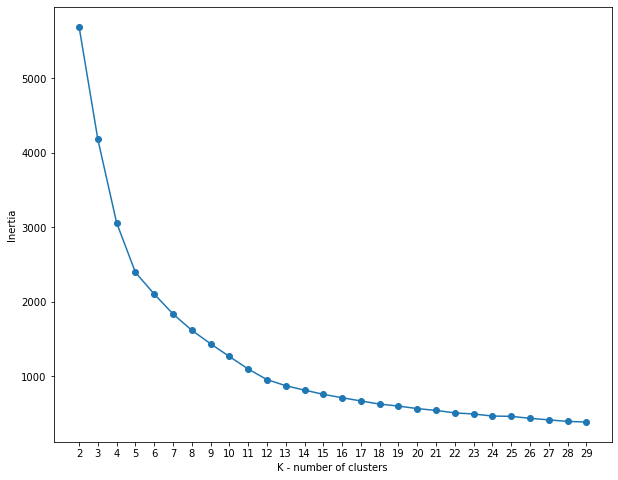

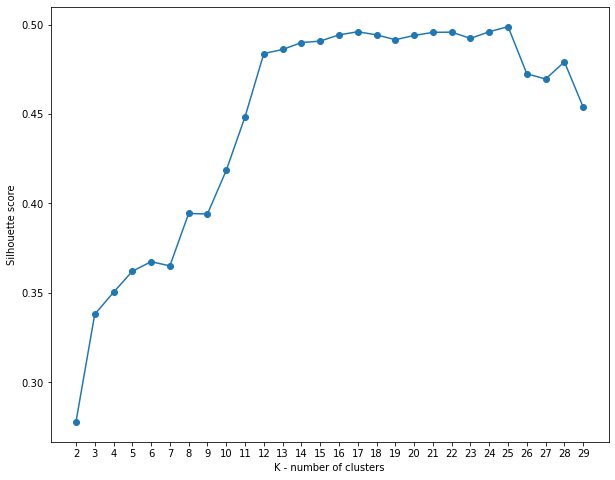

In [11]:
plt.figure(figsize=(10,8))

plt.plot(ks, inertia_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

plt.figure(figsize=(10,8))

plt.plot(ks, silhouette_score_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(ks)

plt.show()

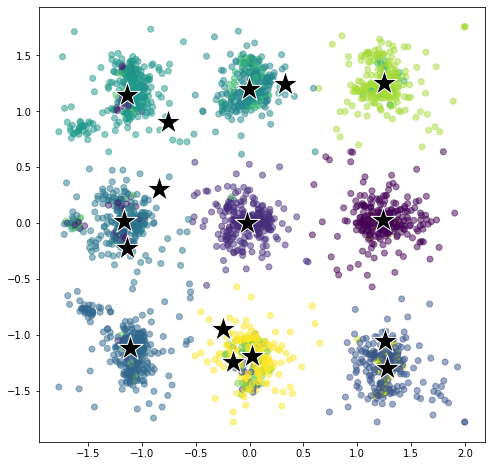

In [12]:
# Instantiate
k_means_model_2= KMeans(n_clusters=16)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()

In [13]:
X_with_labels = pd.DataFrame(X)
X_with_labels['labels'] = cluster_labels

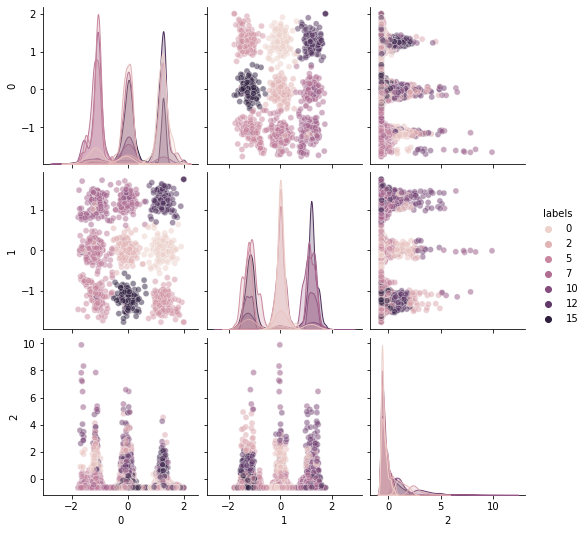

In [14]:
sns.pairplot(X_with_labels, hue='labels', plot_kws={'alpha': 0.5})
plt.show()

In [15]:
silhouette_scores = []
num_clusters = []
epsilons = np.arange(0.1, 1.2, 0.1)

for eps in epsilons:

    # Instantiate
    model = DBSCAN(eps=eps, min_samples=5)

    # Fit
    y_labels = model.fit_predict(X)
    
    # we disregard the noise label -1
    n_clusters = len(np.unique(y_labels[y_labels != -1]))
    print(f'eps = {eps} --- n_clusters: {n_clusters}')
    
    silhouette = silhouette_score(X, y_labels)
    silhouette_scores.append(silhouette)
    num_clusters.append(n_clusters)

eps = 0.1 --- n_clusters: 54
eps = 0.2 --- n_clusters: 19
eps = 0.30000000000000004 --- n_clusters: 4
eps = 0.4 --- n_clusters: 5
eps = 0.5 --- n_clusters: 3
eps = 0.6 --- n_clusters: 1
eps = 0.7000000000000001 --- n_clusters: 1
eps = 0.8 --- n_clusters: 1
eps = 0.9 --- n_clusters: 1
eps = 1.0 --- n_clusters: 1
eps = 1.1 --- n_clusters: 2


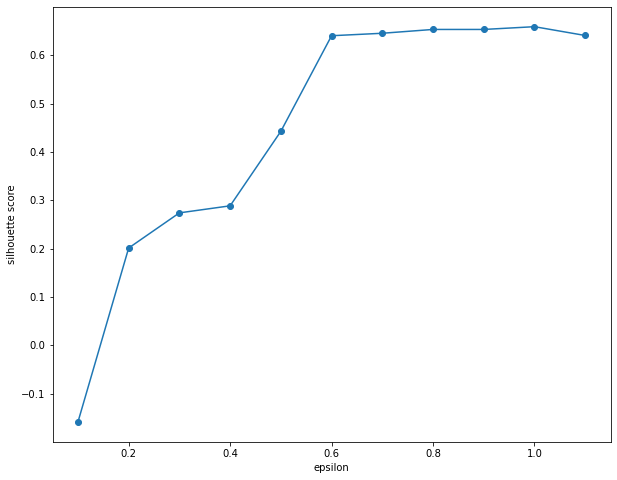

In [16]:
plt.figure(figsize=(10,8))
plt.plot(epsilons, 
         silhouette_scores, 
         marker='o')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.show()